In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import backend as keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, save_model, load_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
import os
from astroNN.nn.layers import MCDropout
import math


Reading JLA covariance matrix and examinate the min, max and mean from it. 

In [2]:
ffnn = tf.keras.models.load_model('../models/FFNN_JLA2.h5')
ffnn_do = tf.keras.models.load_model('..models/FFNN_JLA_DO.h5', custom_objects={'MCDropout': MCDropout})


syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
file = '../data/jla_binned_distances_31nodes_v1.txt'

# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))
nsize = len(syscov)

# scaler_sys = StandardScaler()
# scaler_sys.fit(syscov)
# syscov_sc = scaler_sys.transform(syscov)
data = np.loadtxt(file, skiprows=3)
z_redshift = data[:, 0]
errors = np.diag(syscov).reshape(nsize,)
errors_logs = np.where(errors!= 0, np.log(errors), 0)

print(np.shape(data[:,1]), np.shape(errors), np.shape(syscov))


-0.01084098704 0.02815552265 0.00039265133851975654
(31,) (31,) (31, 31)


In [3]:
scalercov = StandardScaler()
scalercov.fit(syscov)
syscov_sc = scalercov.transform(syscov)

scalerdist = StandardScaler()
scalerdist.fit(data[:,1].reshape(-1,1))
dist_sc = scalerdist.transform(data[:,1].reshape(nsize,1))

scalererr = StandardScaler()
scalererr.fit(errors.reshape(-1,1))
errors_sc = scalerdist.transform(errors.reshape(nsize,1))

Text(0.5, 1.0, 'Original matrix scaled and extended')

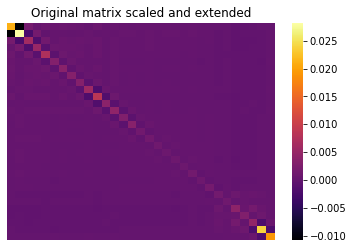

In [4]:
sns.heatmap(syscov, 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title('Original matrix scaled and extended')

In [5]:
def permutMatrix(omatrix, nmatrix):
    nsize = len(omatrix)
    matrixset = np.zeros((nmatrix, nsize, nsize))
    magnitudes = np.zeros((nmatrix, nsize, nsize))
    for it in range(nmatrix):
        perm = np.random.permutation(nsize)
        P = np.eye(nsize)[perm]
        p = P@omatrix@P.T
        p = symmetrical(p)
        matrixset[it, :, :nsize] = p
        magnitudes[it, :, :] = matrixMag(matrixset[it,:,:])
        
    return matrixset, magnitudes


In [6]:
def symmetrical(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
    #         if np.iscomplex(syscov[i,j]):
    #             print("COMPLEX")
            if matrix[i,j] != matrix[j,i]:
                    if np.abs(matrix[i, j]) < np.abs(matrix[j,i]):
                        matrix[i, j] = matrix[j, i]
                    else:
                        matrix[j, i] = matrix[i, j]
            
    return matrix

In [7]:
def orderMag(number):
    if number == 0.0:
        return 0.0
    else:
        return math.floor(math.log(np.abs(number), 10))

def matrixMag(matrix):
    mshape = np.shape(matrix)
    magMatrix = np.zeros(mshape)
    for row in range(nsize):
        for col in range(nsize):
            magMatrix[row, col] = orderMag(matrix[row, col])
    return magMatrix            

In [8]:
numMatrix = 10000
covset = np.zeros((numMatrix, 31, 31))
permMatrix, magnitudes = permutMatrix(syscov_sc, numMatrix)
# magnitudes = matrixMag(ext_matrix)
print(np.shape(permMatrix))

(10000, 31, 31)


Text(0.5, 1.0, 'PERMUTATED MATRIX (SCALED)')

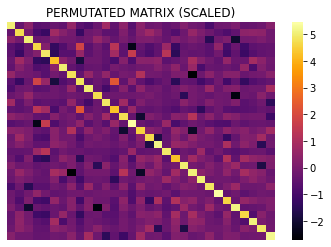

In [9]:
sns.heatmap(pd.DataFrame(permMatrix[0, :, :]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("PERMUTATED MATRIX (SCALED)")


Text(0.5, 1.0, 'PERMUTATED MATRIX')

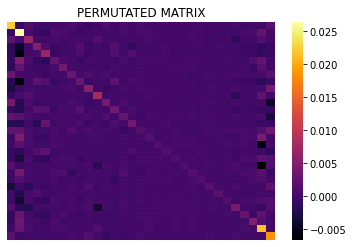

In [10]:
sns.heatmap(scalercov.inverse_transform(permMatrix[0, :, :]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("PERMUTATED MATRIX")

In [11]:
for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    for row in range(nsize):
        for col in range(nsize):
            err = np.random.randn()
            if row == col:
                covset[i, row, col] = permMatrix[i, row, col] + 1e-4*err*10**magnitudes[i, row, col]
            else:
                covset[i, row, col] = permMatrix[i, row, col] + 1e-3*err*10**orderMag(permMatrix[i, row, col])


 Generating 617 matrix

 Generating 1386 matrix 

 Generating 1871 matrix

 Generating 2287 matrix 

 Generating 3419 matrix

 Generating 4047 matrix 

 Generating 4407 matrix 

 Generating 5388 matrix

 Generating 6139 matrix 

 Generating 6906 matrix

 Generating 7565 matrix 

 Generating 8405 matrix

 Generating 8904 matrix 

 Generating 9404 matrix

 Generating 10000 matrix 

In [12]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
# covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)
# np.shape(covset_noise_test)

(10000, 31, 31)


Text(0.5, 1.0, 'TEST MATRIX')

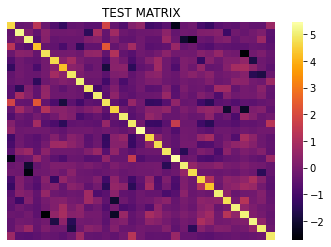

In [13]:
sns.heatmap(pd.DataFrame(covset_test[0,:,:]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("TEST MATRIX")

In [14]:
latent_mean = np.mean(dist_sc)
latent_std = np.std(dist_sc)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=latent_mean, stddev=latent_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [15]:
input_shape = (31, 31, 1)
latent_dim = 2


inputs = tf.keras.Input(shape=input_shape, name='encoder_input')
# ((top_pad, bottom_pad), (left_pad, right_pad))
x = layers.ZeroPadding2D(((5,4),(5,4)))(inputs)
x = layers.Conv2D(64, (5, 5), activation='relu', strides=2, padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
shape_enc = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(50)(x)
x = layers.Dense(10)(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_sigma])

# z = layers.Lambda(sampling)([z_mean, z_log_sigma])
encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 31, 31, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 40, 40, 1)    0           encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 20, 20, 64)   1664        zero_padding2d[0][0]             
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 10, 10, 64)   0           conv2d[0][0]                     
____________________________________________________________________________________________

In [16]:
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(shape_enc[1] * shape_enc[2] * shape_enc[3], activation='relu')(latent_inputs)
x = layers.Reshape((shape_enc[1], shape_enc[2], shape_enc[3]))(x)
x = layers.Dense(10)(x)
x = layers.Dense(50)(x)
x = layers.Conv2DTranspose(16, (3,3), activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, (3,3), activation='linear', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(64, (5,5), activation='linear', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(1, (5,5), activation='relu', strides=2, padding='same')(x)
# x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# x = layers.Conv2D(1, (5, 5), activation='linear', padding='same')(x)
outputs = layers.Cropping2D(cropping=((1, 0), (1, 0)))(x)

# Decoder model
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                192       
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 16)          0         
_________________________________________________________________
dense_5 (Dense)              (None, 2, 2, 10)          170       
_________________________________________________________________
dense_6 (Dense)              (None, 2, 2, 50)          550       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 16)          7216      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 32)          4640

In [17]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_conv')
vae.summary()

Model: "vae_conv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 31, 31, 1)]       0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 28556     
_________________________________________________________________
decoder (Functional)         (None, 31, 31, 1)         65633     
Total params: 94,189
Trainable params: 94,189
Non-trainable params: 0
_________________________________________________________________


In [18]:
# VAE class from https://github.com/keras-team/keras-io
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



In [19]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

covmatrixset = np.concatenate([covset_train, covset_train], axis=0)
covmatrixset = np.expand_dims(covmatrixset, -1).astype("float32")



### TRAINING

In [20]:
vae_train = vae.fit(covmatrixset, epochs=500, batch_size=128)                        

Epoch 1/500
125/125 [==============================] - 6s 40ms/step - loss: -2486.8358 - reconstruction_loss: -3536.0527 - kl_loss: 63.1251
Epoch 2/500
125/125 [==============================] - 5s 40ms/step - loss: -4548.1076 - reconstruction_loss: -4609.4946 - kl_loss: 19.5004
Epoch 3/500
125/125 [==============================] - 5s 40ms/step - loss: -4637.6127 - reconstruction_loss: -4656.5557 - kl_loss: 18.0709
Epoch 4/500
125/125 [==============================] - 5s 40ms/step - loss: -4662.9827 - reconstruction_loss: -4667.4854 - kl_loss: 6.4865
Epoch 5/500
125/125 [==============================] - 5s 40ms/step - loss: -4639.2190 - reconstruction_loss: -4662.1318 - kl_loss: 43.9731
Epoch 6/500
125/125 [==============================] - 5s 40ms/step - loss: -4644.5376 - reconstruction_loss: -4669.0557 - kl_loss: 8.4626
Epoch 7/500
125/125 [==============================] - 5s 40ms/step - loss: -4667.5454 - reconstruction_loss: -4671.7354 - kl_loss: 3.3785
Epoch 8/500
125/125 [==

125/125 [==============================] - 5s 40ms/step - loss: -4671.8003 - reconstruction_loss: -4671.8037 - kl_loss: 0.0031
Epoch 60/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8022 - reconstruction_loss: -4671.8037 - kl_loss: 0.0030
Epoch 61/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8020 - reconstruction_loss: -4671.8057 - kl_loss: 0.0028
Epoch 62/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8029 - reconstruction_loss: -4671.8052 - kl_loss: 0.0023
Epoch 63/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8011 - reconstruction_loss: -4671.8037 - kl_loss: 0.0020
Epoch 64/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8027 - reconstruction_loss: -4671.8057 - kl_loss: 0.0018
Epoch 65/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8015 - reconstruction_loss: -4671.8047 - kl_loss: 0.0017
Epoch 66/500
125/125 [===========

125/125 [==============================] - 5s 41ms/step - loss: -4671.8051 - reconstruction_loss: -4671.8052 - kl_loss: 2.7085e-04
Epoch 117/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8040 - reconstruction_loss: -4671.8047 - kl_loss: 2.4887e-04
Epoch 118/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8028 - reconstruction_loss: -4671.8042 - kl_loss: 2.2978e-04
Epoch 119/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8022 - reconstruction_loss: -4671.8047 - kl_loss: 2.1186e-04
Epoch 120/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8037 - reconstruction_loss: -4671.8052 - kl_loss: 1.9611e-04
Epoch 121/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8048 - reconstruction_loss: -4671.8052 - kl_loss: 1.8252e-04
Epoch 122/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8030 - reconstruction_loss: -4671.8042 - kl_loss: 1.6953e-04

125/125 [==============================] - 5s 41ms/step - loss: -4671.8036 - reconstruction_loss: -4671.8047 - kl_loss: 8.7006e-06
Epoch 173/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8025 - reconstruction_loss: -4671.8042 - kl_loss: 8.0550e-06
Epoch 174/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8055 - reconstruction_loss: -4671.8052 - kl_loss: 7.7379e-06
Epoch 175/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8071 - reconstruction_loss: -4671.8057 - kl_loss: 7.7962e-06
Epoch 176/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8046 - reconstruction_loss: -4671.8047 - kl_loss: 6.8597e-06
Epoch 177/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8046 - reconstruction_loss: -4671.8057 - kl_loss: 6.4618e-06
Epoch 178/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8059 - reconstruction_loss: -4671.8052 - kl_loss: 6.1376e-06

125/125 [==============================] - 5s 41ms/step - loss: -4671.8024 - reconstruction_loss: -4671.8057 - kl_loss: 8.3199e-07
Epoch 229/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8024 - reconstruction_loss: -4671.8042 - kl_loss: 5.6013e-07
Epoch 230/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8066 - reconstruction_loss: -4671.8057 - kl_loss: 7.3908e-07
Epoch 231/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8038 - reconstruction_loss: -4671.8057 - kl_loss: 5.9764e-07
Epoch 232/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8027 - reconstruction_loss: -4671.8047 - kl_loss: 6.2148e-07
Epoch 233/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8048 - reconstruction_loss: -4671.8047 - kl_loss: 5.4928e-07
Epoch 234/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8047 - reconstruction_loss: -4671.8047 - kl_loss: 5.2111e-07

125/125 [==============================] - 5s 40ms/step - loss: -4671.8022 - reconstruction_loss: -4671.8042 - kl_loss: 9.2966e-08
Epoch 285/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8042 - reconstruction_loss: -4671.8062 - kl_loss: 2.2443e-07
Epoch 286/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8047 - reconstruction_loss: -4671.8052 - kl_loss: 1.1960e-07
Epoch 287/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8035 - reconstruction_loss: -4671.8047 - kl_loss: 1.0888e-07
Epoch 288/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8044 - reconstruction_loss: -4671.8047 - kl_loss: 1.3397e-07
Epoch 289/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8039 - reconstruction_loss: -4671.8047 - kl_loss: 1.2949e-07
Epoch 290/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8016 - reconstruction_loss: -4671.8052 - kl_loss: 1.3203e-07

125/125 [==============================] - 5s 41ms/step - loss: -4671.8048 - reconstruction_loss: -4671.8052 - kl_loss: 8.4642e-08
Epoch 341/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8036 - reconstruction_loss: -4671.8052 - kl_loss: 1.2659e-07
Epoch 342/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8045 - reconstruction_loss: -4671.8052 - kl_loss: 6.8204e-08
Epoch 343/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8033 - reconstruction_loss: -4671.8057 - kl_loss: 8.5868e-09
Epoch 344/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8031 - reconstruction_loss: -4671.8037 - kl_loss: 1.0421e-07
Epoch 345/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8035 - reconstruction_loss: -4671.8047 - kl_loss: 8.0328e-08
Epoch 346/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8054 - reconstruction_loss: -4671.8052 - kl_loss: 9.5842e-08

125/125 [==============================] - 5s 40ms/step - loss: -4671.8040 - reconstruction_loss: -4671.8052 - kl_loss: 2.9802e-08
Epoch 397/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8030 - reconstruction_loss: -4671.8042 - kl_loss: 5.2452e-08
Epoch 398/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8039 - reconstruction_loss: -4671.8042 - kl_loss: 4.2200e-08
Epoch 399/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8052 - reconstruction_loss: -4671.8057 - kl_loss: 1.8835e-08
Epoch 400/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8054 - reconstruction_loss: -4671.8042 - kl_loss: 6.1750e-08
Epoch 401/500
125/125 [==============================] - 5s 40ms/step - loss: -4671.8027 - reconstruction_loss: -4671.8042 - kl_loss: 2.5988e-08
Epoch 402/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8042 - reconstruction_loss: -4671.8057 - kl_loss: 5.3406e-08

125/125 [==============================] - 5s 41ms/step - loss: -4671.8027 - reconstruction_loss: -4671.8047 - kl_loss: 2.4796e-08
Epoch 453/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8033 - reconstruction_loss: -4671.8037 - kl_loss: 2.9802e-08
Epoch 454/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8044 - reconstruction_loss: -4671.8047 - kl_loss: 2.4796e-08
Epoch 455/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8057 - reconstruction_loss: -4671.8057 - kl_loss: 1.7643e-08
Epoch 456/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8030 - reconstruction_loss: -4671.8042 - kl_loss: 1.6689e-08
Epoch 457/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8032 - reconstruction_loss: -4671.8057 - kl_loss: 1.7643e-08
Epoch 458/500
125/125 [==============================] - 5s 41ms/step - loss: -4671.8040 - reconstruction_loss: -4671.8047 - kl_loss: 3.1948e-08

(array([-4800., -4600., -4400., -4200., -4000., -3800., -3600., -3400.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

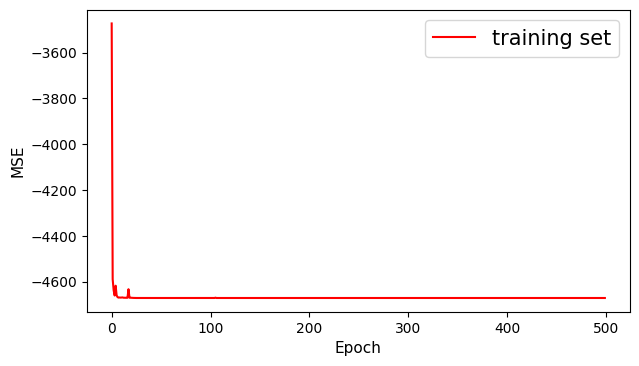

In [21]:
plt.figure(figsize=(7, 4), dpi=100)

plt.plot(vae_train.history['loss'], color='r', )

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

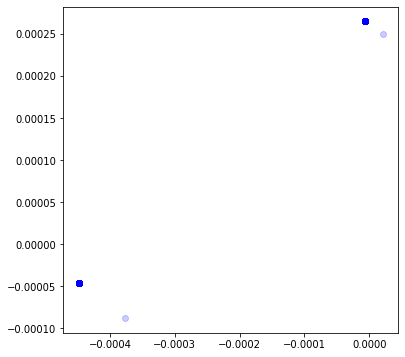

In [22]:
x_test_encoded = encoder.predict(covset_test)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[ 0], x_test_encoded[1], marker='o', c='blue', alpha=0.2)
# plt.colorbar()
plt.show()

## Generate synthetic covariance matrix

In [23]:
np.shape(syscov_sc), np.shape(covset_test), np.shape(covset_test[0])

((31, 31), (2000, 31, 31), (31, 31))

In [24]:
ztest1 = encoder.predict(covset_test[0].reshape((1,31,31)))
ztest1

[array([[-4.4834614e-04, -7.2442926e-06]], dtype=float32),
 array([[-4.5825727e-05,  2.6470865e-04]], dtype=float32),
 array([[-2.4926639, -1.2739067]], dtype=float32)]

(1, 31, 31, 1)


<AxesSubplot:>

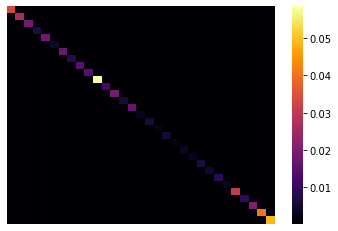

In [25]:
pred_matrix = decoder.predict(ztest1[1])
print(np.shape(pred_matrix))
pred_cov_sc = pred_matrix[0, :, :nsize, 0]
pred_cov = scalercov.inverse_transform(pred_cov_sc)

sns.heatmap(pd.DataFrame(pred_cov), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

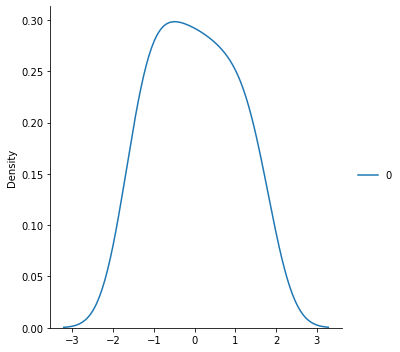

In [26]:
sns.displot(dist_sc, kind='kde')

In [27]:
zmean = np.mean(dist_sc)
zstd = np.std(dist_sc)
# zmean = 0.0
# zstd = 0.5
zmean, zstd

(4.226010222766725e-16, 1.0000000000000002)

In [28]:
z_sample = np.array([[zmean, zstd]])
pred_matrix = decoder.predict(z_sample)

<AxesSubplot:>

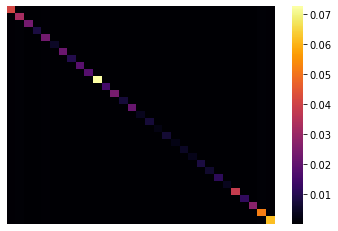

In [29]:
pred_cov_sc = pred_matrix[0, :, :nsize, 0]
pred_cov = scalercov.inverse_transform(pred_cov_sc)

sns.heatmap(pred_cov, 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [30]:
np.savetxt("fake_binned_JLA_COVdecodedTEST2vae.dat", pred_cov, delimiter= " ", header="#fake COV")

# Test with new data

In [36]:
ranz = z_redshift

index = np.argsort(ranz)

pred_random = ffnn.predict(np.log(ranz))
# pred_dl = scalerdl.inverse_transform(pred_random[:,0].reshape(-1,1))
pred_dl = pred_random[:,0][index].reshape(-1,1)
pred_err = np.exp(pred_random[:,1][index].reshape(-1,1))

fake_data = np.stack((ranz[index], pred_dl.reshape(31,)[index]), axis=1)

np.savetxt("fake_binned_JLA2TEST3.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')

In [37]:
pred_dl_sc = scalerdist.transform(pred_dl)
zmean = np.mean(pred_dl_sc)
zstd = np.std(pred_dl_sc)
zmean, zstd

(-0.024898464, 1.0072505)

In [38]:
z_sample = np.array([[zmean, zstd]])
newmatrix = decoder.predict(z_sample)

<AxesSubplot:>

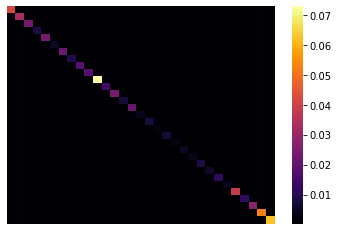

In [39]:
newmatrixr = scalercov.inverse_transform(newmatrix.reshape(31,31))
# # clean_imgr = clean_img[0,:,:,0].reshape(31,31)

sns.heatmap(pd.DataFrame(newmatrixr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [40]:
np.savetxt("fake_binned_JLA_COVdecodedTEST3vae.dat", newmatrixr, delimiter= " ", header="#fake COV")